# Bayth × (SST × CDOM) Combined Analysis

This notebook replicates the workflows of `test_bayth.ipynb` (bathymetry processing) and `test_cdomsstv4.ipynb` (CDOM and SST processing), then multiplies the bathymetry index by the combined (SST × CDOM) index to produce a final plot.

**Workflow:**
1. Load and index bathymetry data for the region.
2. Process and index CDOM and SST data as in `test_cdomsstv4`.
3. Multiply the bathymetry index by the (SST × CDOM) index.
4. Plot the final combined product.

In [16]:
# Import essential libraries
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import binned_statistic_2d
import xarray as xr # For inspecting NetCDF variables
import matplotlib.colors
import cmocean # For specialized oceanographic colormaps

import sys
sys.dont_write_bytecode = True

# Import custom pipeline components
import importlib
import l2_pipeline # Import the module itself to reload
importlib.reload(l2_pipeline)
from l2_pipeline import L2DatasetLoader, GPUDataExtractor, SelectiveInterpolator

# Suppress RuntimeWarnings that can occur with NaNs in calculations
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib') # Ignore Matplotlib UserWarnings for set_bad

In [17]:
# --- Shared Geographical and Binning Parameters ---
# For combined analysis, a common bounding box is essential.
# Let's use a region that typically has both signals, e.g., Texas-Louisiana Shelf.
lon_min, lon_max = -95.0, -88.0 # Adjusted for potential overlap
lat_min, lat_max = 27.5, 30.5

lat_bins = 200 # Number of latitude bins (height)
lon_bins = 300 # Number of longitude bins (width)

# --- CDOM Calculation Constants ---
B0 = 0.2487
B1 = 14.028
B2 = 4.085

# --- L2 RRS Data Configuration (for CDOM) ---
data_dir_l2_rrs = r"E:\satdata\Texas Louisiana Shelf_2024-06-01_2024-06-30"
rrs_vars_list = ['Rrs_412', 'Rrs_555']
rrs_data_group = 'geophysical_data'
interpolation_threshold_cdom = 32

# --- MODIS L2P Data Configuration (for SST) ---
data_dir_sst = r"E:\satdata\MODIS_A-JPL-L2P-v2019.0_Texas Louisiana Shelf_2024-06-01_2024-06-30"
sst_variable_to_plot = 'sea_surface_temperature'
# For MODIS L2P, lat and lon are often 2D data variables.
sst_variables_to_load = [sst_variable_to_plot, 'lat', 'lon']
sst_data_group = None # Variables typically in root for MODIS L2P
min_sst_celsius_threshold = -2.0 # More realistic threshold for SST after Celsius conversion
interpolation_threshold_sst = 32

print(f"Region: Lon ({lon_min}, {lon_max}), Lat ({lat_min}, {lat_max})")
print(f"Grid: {lat_bins} lat bins, {lon_bins} lon bins")

Region: Lon (-95.0, -88.0), Lat (27.5, 30.5)
Grid: 200 lat bins, 300 lon bins


In [18]:
nc_files_rrs = glob.glob(os.path.join(data_dir_l2_rrs, '**', '*.nc'), recursive=True)
if not nc_files_rrs:
    print(f"Warning: No .nc files found for L2 RRS in {data_dir_l2_rrs}.")
else:
    print(f"Found {len(nc_files_rrs)} L2 RRS files for CDOM processing.")
# nc_files_rrs = nc_files_rrs[:5] # Limiting for quick test
# print(f"Using {len(nc_files_rrs)} L2 RRS files.")

Found 42 L2 RRS files for CDOM processing.


In [19]:
datasets_rrs = []
if nc_files_rrs:
    try:
        loader_rrs = L2DatasetLoader(variables=rrs_vars_list, group=rrs_data_group)
        datasets_rrs = loader_rrs.load_multiple(nc_files_rrs)
        print(f"Successfully loaded {len(datasets_rrs)} L2 RRS datasets for CDOM.")
    except Exception as e:
        print(f"Error loading L2 RRS datasets: {e}")
else:
    print("No L2 RRS files found to load for CDOM.")

Successfully loaded 42 L2 RRS datasets for CDOM.


In [20]:
lon_rrs_flat, lat_rrs_flat, rrs_vars_data_flat = np.array([]), np.array([]), {var: np.array([]) for var in rrs_vars_list}
if datasets_rrs:
    try:
        extractor_rrs = GPUDataExtractor(variables=rrs_vars_list)
        lon_rrs_flat, lat_rrs_flat, rrs_vars_data_flat = extractor_rrs.extract(datasets_rrs)
        print(f"L2 RRS data extraction for CDOM complete. Extracted {len(lon_rrs_flat)} data points.")
    except Exception as e:
        print(f"Error during L2 RRS data extraction: {e}")
else:
    print("No L2 RRS datasets loaded, skipping L2 RRS data extraction for CDOM.")

L2 RRS data extraction for CDOM complete. Extracted 12725916 data points.


In [21]:
cdom_values = np.array([])
final_lon_cdom, final_lat_cdom, final_cdom_raw = np.array([]), np.array([]), np.array([])

if lon_rrs_flat.size > 0 and rrs_vars_data_flat:
    Rss412 = rrs_vars_data_flat.get(rrs_vars_list[0], np.array([]))
    Rss555 = rrs_vars_data_flat.get(rrs_vars_list[1], np.array([]))
    
    if Rss412.size > 0 and Rss555.size > 0 and Rss412.shape == lon_rrs_flat.shape and Rss555.shape == lon_rrs_flat.shape:
        term_ratio = Rss412 / Rss555
        term_numerator = term_ratio - B0
        term_division = term_numerator / B2
        valid_log_mask = term_division > 0
        
        cdom_values_temp = np.full_like(term_division, np.nan)
        if np.any(valid_log_mask):
            cdom_values_temp[valid_log_mask] = (np.log(term_division[valid_log_mask])) / (-B1)
        
        cdom_values = cdom_values_temp
        print(f"CDOM calculation complete. Min: {np.nanmin(cdom_values):.4f}, Max: {np.nanmax(cdom_values):.4f}")

        valid_mask = ~np.isnan(lon_rrs_flat) & ~np.isnan(lat_rrs_flat) & ~np.isnan(cdom_values)
        final_lon_cdom = lon_rrs_flat[valid_mask]
        final_lat_cdom = lat_rrs_flat[valid_mask]
        final_cdom_raw = cdom_values[valid_mask]
        print(f"Filtered NaNs for CDOM data, {len(final_lon_cdom)} valid data points remaining.")
    else:
        print("Skipping CDOM calculation: Rrs_412 or Rrs_555 data not available, empty, or shape mismatch.")
else:
    print("Skipping CDOM data processing: No L2 RRS data extracted.")

CDOM calculation complete. Min: -inf, Max: 1.0487
Filtered NaNs for CDOM data, 12472520 valid data points remaining.


In [22]:
binned_cdom_interpolated = np.array([[]])
lat_edges_grid, lon_edges_grid = None, None # To store grid edges for both CDOM and SST

if final_lon_cdom.size > 0:
    clip_mask_cdom = (
        (final_lon_cdom >= lon_min) & (final_lon_cdom <= lon_max) &
        (final_lat_cdom >= lat_min) & (final_lat_cdom <= lat_max)
    )
    clipped_lon_cdom = final_lon_cdom[clip_mask_cdom]
    clipped_lat_cdom = final_lat_cdom[clip_mask_cdom]
    clipped_cdom_raw = final_cdom_raw[clip_mask_cdom]
    print(f"Clipped CDOM data to bounding box. {len(clipped_lon_cdom)} points remaining.")

    if clipped_lon_cdom.size > 0:
        binned_cdom_raw_stat, lat_edges_grid, lon_edges_grid, _ = binned_statistic_2d(
            clipped_lat_cdom, clipped_lon_cdom, clipped_cdom_raw,
            statistic='mean', bins=[lat_bins, lon_bins], 
            range=[[lat_min, lat_max], [lon_min, lon_max]]
        )
        print("2D binning complete for CDOM.")
        
        binned_cdom_interpolated = SelectiveInterpolator.interpolate(
            binned_cdom_raw_stat, lat_edges_grid, lon_edges_grid, threshold=interpolation_threshold_cdom
        )
        print(f"Selective NaN interpolation complete for CDOM (threshold: {interpolation_threshold_cdom} bins).")
        if not np.any(~np.isnan(binned_cdom_interpolated)): print("Warning: Interpolated CDOM is all NaNs.")

    else:
        print("No CDOM data points within the bounding box to bin.")
        binned_cdom_interpolated = np.full((lat_bins, lon_bins), np.nan) # Ensure array exists
else:
    print("No valid CDOM data to clip, bin, or interpolate.")
    binned_cdom_interpolated = np.full((lat_bins, lon_bins), np.nan) # Ensure array exists

if lat_edges_grid is None or lon_edges_grid is None: # Create dummy grid if not made
    lat_edges_grid = np.linspace(lat_min, lat_max, lat_bins + 1)
    lon_edges_grid = np.linspace(lon_min, lon_max, lon_bins + 1)
    print("Warning: CDOM grid edges were not created from data; using linspace. Plotting might be affected if no data.")

Clipped CDOM data to bounding box. 844876 points remaining.
2D binning complete for CDOM.
Selective NaN interpolation complete for CDOM (threshold: 32 bins).


SST

In [23]:
# Use L3DatasetLoader to load MUR L4 SST
from l3_pipeline import L3DatasetLoader

data_dir_mur_l4 = r"E:\satdata\MUR-JPL-L4-GLOB-v4.1_Texas Louisiana Shelf_2024-06-01_2024-06-30"
mur_l4_files = glob.glob(os.path.join(data_dir_mur_l4, '*.nc'))
if not mur_l4_files:
    print(f"Warning: No MUR L4 files found in {data_dir_mur_l4}")
else:
    print(f"Found {len(mur_l4_files)} MUR L4 files.")

mur_l4_variable = 'analysed_sst'
l3_loader = L3DatasetLoader(variables=[mur_l4_variable], bbox=(lon_min, lon_max, lat_min, lat_max))
mur_l4_datasets = l3_loader.load_multiple(mur_l4_files)

if mur_l4_datasets:
    # For simplicity, use the first dataset (could be extended to combine multiple days)
    mur_l4_ds = mur_l4_datasets[0]
    mur_l4_sst = mur_l4_ds[mur_l4_variable].values
    mur_l4_lat = mur_l4_ds['lat'].values
    mur_l4_lon = mur_l4_ds['lon'].values
    # Convert SST from Kelvin to Celsius
    mur_l4_sst_celsius = mur_l4_sst - 273.15
    print(f"Loaded MUR L4 SST. Shape: {mur_l4_sst_celsius.shape}, Range: {np.nanmin(mur_l4_sst_celsius):.2f} to {np.nanmax(mur_l4_sst_celsius):.2f} °C")
else:
    mur_l4_sst_celsius = np.full((lat_bins, lon_bins), np.nan)
    mur_l4_lat = np.linspace(lat_min, lat_max, lat_bins)
    mur_l4_lon = np.linspace(lon_min, lon_max, lon_bins)
    print("No valid MUR L4 SST data loaded.")

Found 31 MUR L4 files.


f:\Programming\GitHub\nasa-murep-local\cdom_sst\l3_pipeline.py:24: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(file_path)
f:\Programming\GitHub\nasa-murep-local\cdom_sst\l3_pipeline.py:24: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's defaul

Loaded MUR L4 SST. Shape: (1, 301, 701), Range: 26.36 to 28.97 °C


In [24]:
def index_sst_maps(data_array, sst_min, sst_max):
    original_nans = np.isnan(data_array)
    indexed = (sst_max - data_array) / (sst_max - sst_min)
    indexed = np.clip(indexed, 0, 1)
    indexed[original_nans] = np.nan
    return indexed

sst_indexed = index_sst_maps(mur_l4_sst_celsius, sst_min=26, sst_max=28)
print(f"Indexed MUR L4 SST: {np.nanmin(sst_indexed):.4f} to {np.nanmax(sst_indexed):.4f}")

Indexed MUR L4 SST: 0.0000 to 0.8225


In [25]:
# Ensure CDOM and SST grids are compatible (interpolate CDOM if needed)
from scipy.interpolate import griddata

if binned_cdom_interpolated.shape != mur_l4_sst_celsius.shape:
    # Interpolate CDOM to MUR L4 grid
    cdom_lat_centers = (lat_edges_grid[:-1] + lat_edges_grid[1:]) / 2
    cdom_lon_centers = (lon_edges_grid[:-1] + lon_edges_grid[1:]) / 2
    cdom_lon_mesh, cdom_lat_mesh = np.meshgrid(cdom_lon_centers, cdom_lat_centers)
    mur_lon_mesh, mur_lat_mesh = np.meshgrid(mur_l4_lon, mur_l4_lat)
    cdom_interp_flat = griddata(
        (cdom_lat_mesh.flatten(), cdom_lon_mesh.flatten()),
        binned_cdom_interpolated.flatten(),
        (mur_lat_mesh, mur_lon_mesh),
        method='linear',
        fill_value=np.nan
    )
    cdom_for_combined = cdom_interp_flat
else:
    cdom_for_combined = binned_cdom_interpolated

# Normalize CDOM using the custom function (0.01->0, 0.16->1)
def normalize_cdom_custom(data_array, cdom_min=0.01, cdom_max=0.16):
    clamped_data = np.clip(data_array, cdom_min, cdom_max)
    normalized_array = (clamped_data - cdom_min) / (cdom_max - cdom_min)
    normalized_array[np.isnan(data_array)] = np.nan
    return normalized_array

cdom_normalized = normalize_cdom_custom(cdom_for_combined, cdom_min=0.01, cdom_max=0.16)
print(f"Normalized CDOM (custom): {np.nanmin(cdom_normalized):.4f} to {np.nanmax(cdom_normalized):.4f}")

# Multiply the two normalized maps
combined_product = cdom_normalized * sst_indexed
print(f"Combined product range: {np.nanmin(combined_product):.4f} to {np.nanmax(combined_product):.4f}")

Normalized CDOM (custom): 0.0000 to 1.0000
Combined product range: 0.0000 to 0.8225


In [26]:
# --- Bathymetry: Load, index, and invert as in test_bayth ---
bathy_nc_path = r"E:/geodata/gebco_2024_sub_ice_topo/GEBCO_2024_sub_ice_topo.nc"
ds_bathy = xr.open_dataset(bathy_nc_path)

# Subset bathymetry to the same region as the analysis
bathy_subset = ds_bathy.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))

# GEBCO bathymetry variable is usually called 'elevation' or 'z', check which exists
bathy_var = None
for v in ['elevation', 'z', 'bathymetry']:
    if v in bathy_subset.variables:
        bathy_var = v
        break
if bathy_var is None:
    raise ValueError('No bathymetry variable found in GEBCO file.')

bathy = bathy_subset[bathy_var].values


In [27]:
# Index and invert bathymetry as in test_bayth (min_bathy=-20, max_bathy=0)
min_bathy, max_bathy = -30, -10
indexed_bathymetry = np.zeros_like(bathy, dtype=np.float32)
mask = (bathy >= min_bathy) & (bathy <= max_bathy)
indexed_bathymetry[mask] = (bathy[mask] - min_bathy) / (max_bathy - min_bathy)
indexed_bathymetry[bathy > max_bathy] = 1.0
indexed_bathymetry_inverted = 1.0 - indexed_bathymetry

In [28]:
# --- Interpolate indexed_bathymetry_inverted to the grid of combined_product ---
# Get bathy lat/lon arrays
bathy_lats = bathy_subset['lat'].values
bathy_lons = bathy_subset['lon'].values

# If bathy is 2D, get meshgrid; if 1D, meshgrid from lats/lons
if bathy.ndim == 2:
    bathy_lon_mesh, bathy_lat_mesh = np.meshgrid(bathy_lons, bathy_lats)
else:
    bathy_lon_mesh, bathy_lat_mesh = np.meshgrid(bathy_lons, bathy_lats)

# Target grid for interpolation: mur_l4_lat, mur_l4_lon (assume 1D, typical for L3)
if mur_l4_lat.ndim == 1 and mur_l4_lon.ndim == 1:
    target_lon_mesh, target_lat_mesh = np.meshgrid(mur_l4_lon, mur_l4_lat)
else:
    target_lon_mesh, target_lat_mesh = mur_l4_lon, mur_l4_lat

from scipy.interpolate import griddata
bathy_interp = griddata(
    (bathy_lat_mesh.flatten(), bathy_lon_mesh.flatten()),
    indexed_bathymetry_inverted.flatten(),
    (target_lat_mesh, target_lon_mesh),
    method='nearest',
    fill_value=np.nan
)

In [29]:
# --- Multiply bathymetry by combined_product ---
final_combined = bathy_interp * combined_product

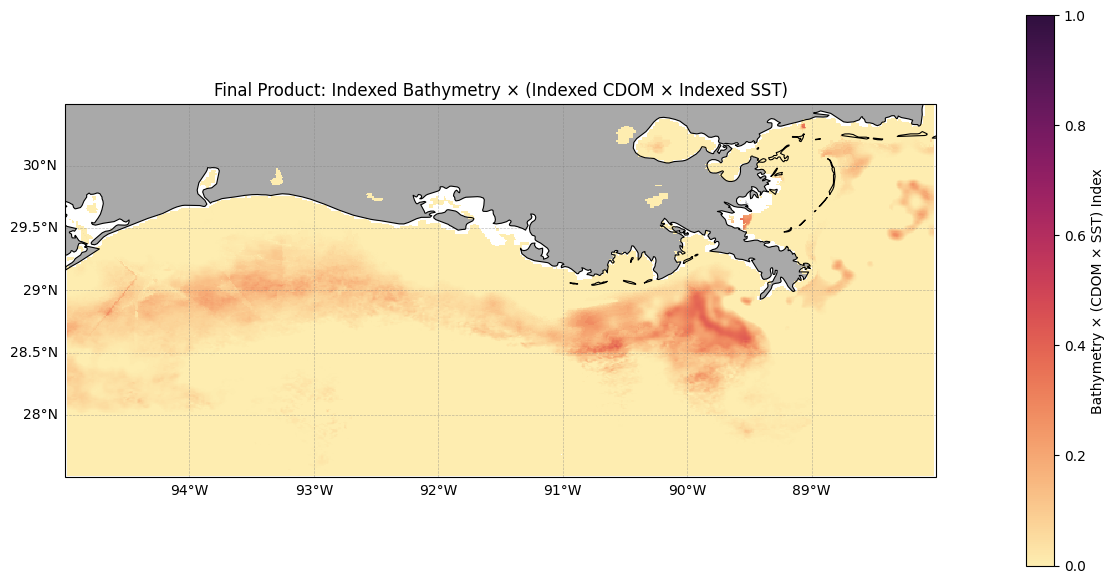

In [30]:
# --- Plot the final product ---
def get_bin_edges_from_centers(centers):
    # Assumes centers are sorted
    diffs = np.diff(centers)
    edges = np.concatenate(([centers[0] - diffs[0]/2],
                            centers[:-1] + diffs/2,
                            [centers[-1] + diffs[-1]/2]))
    return edges

# If mur_l4_lat/lon are 1D (typical for L3), get edges
if mur_l4_lat.ndim == 1 and mur_l4_lon.ndim == 1:
    lat_edges = get_bin_edges_from_centers(mur_l4_lat)
    lon_edges = get_bin_edges_from_centers(mur_l4_lon)
    plot_lat_edges = lat_edges
    plot_lon_edges = lon_edges
else:
    plot_lat_edges = mur_l4_lat
    plot_lon_edges = mur_l4_lon

final_combined = np.squeeze(final_combined)

fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([mur_l4_lon[0], mur_l4_lon[-1], mur_l4_lat[0], mur_l4_lat[-1]], crs=ccrs.PlateCarree())

comb_vmin, comb_vmax = 0, 1

combined_plot = ax.pcolormesh(plot_lon_edges, plot_lat_edges, final_combined,
                            cmap=cmocean.cm.matter, shading='auto',
                            vmin=comb_vmin, vmax=comb_vmax, transform=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black', zorder=3)
ax.add_feature(cfeature.LAND, facecolor='darkgray', zorder=0)
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='dimgray', zorder=2)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

cbar = fig.colorbar(combined_plot, ax=ax, label='Bathymetry × (CDOM × SST) Index', shrink=0.7, pad=0.08)

plt.title("Final Product: Indexed Bathymetry × (Indexed CDOM × Indexed SST)", fontsize=12)
plt.tight_layout(pad=0.5)
plt.show()